<a href="https://colab.research.google.com/github/prathibaleri20/dgcan_fashion_mist/blob/main/dgcan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import math                     #data normalization
import matplotlib.pyplot as plt #plot images of outputs
import os                       # to read
import imageio                  # to create anim of outputs
from sklearn import preprocessing #for standardizing the dataset


In [7]:
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape,y_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28) (60000,)


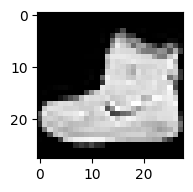

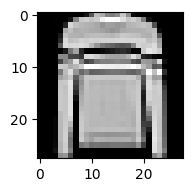

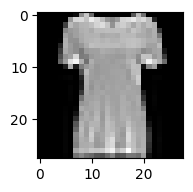

In [9]:
#plotting
for i in range(3):  #we plot 10 images
  plt.subplot(1,3,1+i)   #2 rows, 5 cols, index of the image
  plt.imshow(x_train[i*5], cmap=plt.get_cmap('gray'))
  plt.show()

In [10]:
#Convert the train dataset into a 3D DATASET of stacked 3D images
image_width = x_train.shape[1];
x_train = np.reshape(x_train, [-1, image_width ,image_width , 1]).astype('float32')
#Check the shape of the data now
x_train.shape


(60000, 28, 28, 1)

In [11]:
# Normalize the images to [-1, 1] [Normalized Value = (value - mean)/mean]
x_train = (x_train - 127.5) / 127.5
#Generator Initializations
noise_length = 100


In [12]:
def create_generator_model(image_size=28, noise_input=100):

   #Create input layer
   input_layer = tf.keras.layers.Input(shape=(noise_input,))

   #First upsampling to 7X7X256
   #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
   x = tf.keras.layers.Dense(7 * 7 * 256)(input_layer)
   x = tf.keras.layers.Reshape((7, 7, 256))(x)

   #Upscaling 1 : 128 filters, (2,2) stride
   #Input = 7X7X256
   #Output at this stage = 14X14X128
   #Syntax Note: kernel size can be specified as a tuple or integer or list
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=2, padding='same')(x)

   #Upscaling 2
   #Input = 14X14X128
   #Output at this stage = 28X28X64
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)

   #Upscaling 3
   #Input = 28X28X64
   #Output at this stage = 28X28X32
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)

   #Upscaling 3
   #Input = 28X28X32
   #Output at this stage = 28X28X1
   #Note that we use tanh activation and not Leaky Relu for the last layer.
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)

   x = tf.keras.layers.Activation('sigmoid')(x)
   #Create the model
   gen_network = tf.keras.models.Model(input_layer, x, name='gen_network')

   return gen_network


In [13]:
def create_discriminator_model(desc_data=[28,28,1,]):

   #A typical Convolution  network for classification is built
   disc_input = tf.keras.layers.Input(desc_data)
   #Input Dimension : 28X28X1
   #Output Dimension : 14X14X32
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(disc_input)
   x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)

   #Input Dimension : 14X14X32
   #Output Dimension : 7X7X64
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)

   #Input Dimension : 7X7X64
   #Output Dimension : 4X4X128
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)

   #Input Dimension : 4X4X128
   #Output Dimension : 4X4X256
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)

   #Input Dimension : Flattened(4X4X256)
   #Output Dimension : 1
   #Flatten the output and build an output layer
   x = tf.keras.layers.Flatten()(x)
   x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

   #Build Model
   disc_network = tf.keras.models.Model(disc_input, x, name='disc_network')

   return disc_network


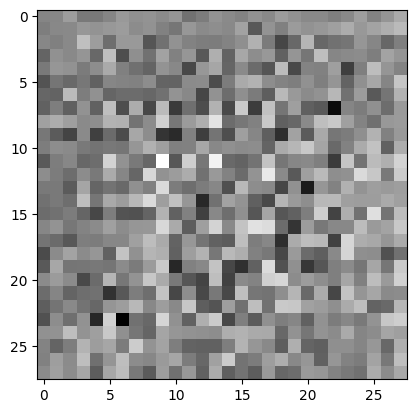

In [14]:
generator = create_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [17]:
#This code will check the functioning of the descriminator against a sample input. As of this point,
#the descriminator is untrained.
discriminator = create_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.5071135]], shape=(1, 1), dtype=float32)


In [32]:
def build_models():

   noise_size = 100
   lr = 2e-4
   decay = 6e-8

   #Build Base Discriminator model
   base_discriminator = create_discriminator_model(desc_data=(28,28,1,))

   #Define optimizer and compile model
   discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs,
                                         outputs=base_discriminator.outputs)
   # Changed lr to learning_rate
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, decay=decay)
   discriminator.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])

   #Build Generator model
   generator = create_generator_model(image_size=28, noise_input=noise_size)

   #Build Frozen Discriminator
   frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs,
                                         outputs=base_discriminator.outputs)
   #Freeze the weights of discriminator during adversarial training
   frozen_discriminator.trainable = False
   #Build Adversarial model
   # Changed lr to learning_rate
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr * 0.5, decay=decay * 0.5)
   #Adversarial = generator + discriminator
   adversarial = tf.keras.models.Model(generator.input,
                       frozen_discriminator(generator.output))

   adversarial.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])

   return generator, discriminator, adversarial

In [19]:
def train_gan(generator, discriminator, adversarial, noise_size=100):

   #Training parameters
   batch_size = 64
   train_steps = 10000   # we are going for 10000 Steps of training
   image_size = 28

   #FASHION MNIST DATASET
   (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

   #Convert the train dataset into a DATASET of stacked 3D images Dimension: (60000,28,28,1)
   x_train = np.reshape(x_train, [-1, image_size, image_size, 1]).astype('float32')

   #Standardize data : 0 to 1
   x_train = x_train / 255

   #Input for testing generator at different intervals, we will generate 16 images
   test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])

   #Start training
   for i in range(train_steps):

       #Train the DISCRIMATOR

       #Step 1. Get images generated by Generator N/W (Fake Images)
       noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
       fake_images = generator.predict(noise_input)

       #Step 2. Get images from actual  training set (Real Images)
       img_indexes = np.random.randint(0, x_train.shape[0], size=batch_size)
       real_images = x_train[img_indexes]

       #Step 3. Prepare input for training Discriminator
       X = np.concatenate((real_images, fake_images))

       #4. Labels for training
       y_real = np.ones((batch_size, 1))
       y_fake = np.zeros((batch_size, 1))
       y = np.concatenate((y_real, y_fake))

       #5. Train the Discriminator Network
       # The train_on_batch() method Runs a single gradient update on a single batch of data.
       d_loss, d_acc = discriminator.train_on_batch(X, y)

       # Now we have updated discriminator weights.We will freeze the discriminator weights to
       #train the adversarial network

       #Train ADVERSARIAL Network

       #1. Prepare input - create a new batch of noise
       X = noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])

       #2. Prepare labels - training Adversarial network to lie :) - All 1s
       y = np.ones((batch_size, 1))

       #3. Train - Pls note Discrimator is not getting trained here
       a_loss, a_acc = adversarial.train_on_batch(X, y)

       if i % 100 == 0:
           #Print loss and Accuracy for both networks
           print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )

       #Save generated images to see how well Generator is doing
       if (i+1) % 500 == 0:

           #Generate 16 images
           fake_images = generator.predict(test_noise_input)

           #Display images
           plot_images(fake_images, i+1)

   #Save Generator model
   generator.save('fashionmnist_generator_dcgan.h5')


In [27]:
def plot_images(fake_images, step):

   plt.figure(figsize=(2.5,2.5))
   num_images = fake_images.shape[0]

   image_size = fake_images.shape[1]
   rows = int(math.sqrt(fake_images.shape[0]))

   for i in range(num_images):
       plt.subplot(rows, rows, i + 1)
       image = np.reshape(fake_images[i], [image_size, image_size])
       plt.imshow(image, cmap='gray')
       plt.axis('off')
   plt.show()

In [34]:
G,D,A= build_models()
G.summary()
D.summary()
A.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "gen_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 14, 14, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 28, 28, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │           801 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,089 (8.95 MB)

 Trainable params: 2,344,129 (8.94 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 7, 7, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080,577 (4.12 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,080,577 (4.12 MB)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 14, 14, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 28, 28, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 28, 28, 1)      │           801 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 1)              │     1,080,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,425,666 (13.07 MB)

 Trainable params: 2,344,129 (8.94 MB)

 Non-trainable params: 1,081,537 (4.13 MB)

In [1]:
import glob
import imageio
anim_file = 'dcfashiongan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
 filenames = glob.glob('D:\Sups\Python\GAN\FASHION_mnist\*.png')
 filenames = sorted(filenames)
 for filename in filenames:
   image = imageio.imread(filename)
   writer.append_data(image)
   image = imageio.imread(filename)
   writer.append_data(image)

